In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.linalg import svd, expm
import time
from numpy import linalg as LA
from scipy.linalg import hadamard, subspace_angles
from numpy.linalg import matrix_rank
from scipy.linalg import expm, svd
from scipy import linalg
import math
import control as ctrl
import matplotlib.pyplot as plt

In [17]:
# Define functions

def lqr_cost(A, B, Q, R, K, x_0, N):
        """
        Computes the LQR cost for a given sequence of states up to a horizon N,
        using the state cost matrix Q, the control cost matrix R, and the
        feedback gain matrix K.

        Parameters:
        Q (np.ndarray): The state cost matrix.
        R (np.ndarray): The control cost matrix.
        K (np.ndarray): The feedback gain matrix.
        x_list (List[np.ndarray]): The list of state vectors.
        N (int): The horizon up to which to compute the cost.

        Returns:
        float: The computed LQR cost.
        """
    
        pk = Q.copy()
        for t in range(N + 1):
            pk = Q + K.T @ R @ K + (A - B @ K).T @ pk @ (A - B @ K)
        cost = x_0.T @ pk @ x_0
        return cost

def gen_syn_data1(M, N, dim_lat, nu):
    # Extracting A and B matrices from M
    A = np.array(M)[:, 0:dim_lat]
    B = np.array(M)[:, dim_lat:dim_lat + nu]

    # System dynamics - Non-IID
    X = np.zeros((dim_lat + nu, N))
    Y = np.zeros((dim_lat, N + 1))
    sigu = 1
    sigw = 1

    rho = 5
    Sigma = rho * np.eye(dim_lat) + 2 * np.random.rand(dim_lat, dim_lat)
    Sigma_W = 0.5 * (Sigma + Sigma.T)

    Sigma_y = linalg.solve_discrete_lyapunov(A, (sigu ** 2) * np.dot(B, B.T) + Sigma_W)

    Ys = sqrtm(Sigma_y) @ np.random.normal(0, 1, (dim_lat, 1))
    Y[:,0] = Ys[:,0]
    
    
    for t in range(N):
        u = np.random.normal(0, sigu, (nu, 1))
        w = sqrtm(Sigma_W) @ np.random.normal(0, 1, (dim_lat, 1))
        X[:dim_lat, t] = Y[:, t]
        X[dim_lat:dim_lat+nu] = u
        Y_t_1 = np.dot(M, X[:, t]) + w
        Y[:, t+1] = Y_t_1[:,0]

    Y = Y[:, 1:]  # Remove the first column from Y

    return X, Y, A, B


def gen_syn_data2(M, N, dim_lat, nu, Phi_hat, F):
    
    # Extracting A and B matrices from M
    A = np.array(M)[:, 0:dim_lat]
    B = np.array(M)[:, dim_lat:dim_lat + nu]

    # System dynamics - Non-IID
    X = np.zeros((dim_lat + nu, N))
    Y = np.zeros((dim_lat, N + 1))
    sigu = 1
    sigw = 1

    rho = 5
    Sigma = rho * np.eye(dim_lat) + 2 * np.random.rand(dim_lat, dim_lat)
    Sigma_W = 0.5 * (Sigma + Sigma.T)

    Sigma_y = linalg.solve_discrete_lyapunov(A, (sigu ** 2) * np.dot(B, B.T) + Sigma_W)

    Ys = sqrtm(Sigma_y) @ np.random.normal(0, 1, (dim_lat, 1))
    Y[:,0] = Ys[:,0]
    
    
    M_MAP = np.dot(F,Phi_hat)
    A_MAP = np.array(M_MAP)[:, 0:dim_lat]
    B_MAP = np.array(M_MAP)[:, dim_lat:dim_lat + nu]
    
    K_MAP, _ , _ = ctrl.dlqr(A_MAP, B_MAP, np.eye(A_MAP.shape[0]), np.eye(B_MAP.shape[1]))
    
    for t in range(N):
        w = sqrtm(Sigma_W) @ np.random.normal(0, 1, (dim_lat, 1))
        X[:dim_lat, t] = Y[:, t]
        X_K = np.zeros([nu,1])
        X_K[:,0] = -np.dot(K_MAP,X[:dim_lat, t])
        
        X[dim_lat:dim_lat+nu] = X_K
        Y_t_1 = np.dot(M, X[:, t]) + w
        Y[:, t+1] = Y_t_1[:,0]

    Y = Y[:, 1:]  # Remove the first column from Y

    return X, Y, A, B






def subspace_distance(Phi_1, Phi_2):
    r = Phi_1.shape[0]
    distance = np.sqrt(r - np.linalg.norm(Phi_1.dot(Phi_2.T), 'fro') ** 2)
    return distance


def grad_F(F,Phi,j,X,Y,lambda_F,ny,r,sigma):
    
    M = len(F)
    T = len(X)
    
    sum_term = 0
    
    for t in range(T):
        Phi_term = np.zeros([ny,r])
        Phi_term[j,:] = np.dot(Phi,X[:,t]).T
        
        sum_term = sum_term + (1/(sigma**2))*np.dot((Y[:,t] - np.dot(np.dot(F,Phi),X[:,t])).T,Phi_term)
    
    grad_weight = -(F[j,:])/(lambda_F**2) + sum_term
    
    return grad_weight


def grad_Phi(F,Phi,j,Xc,Yc,lambda_Phi,sigma):
    
    M = len(F)
    T = len(Xc)
    
    sum_term = 0
    
    for i in range(M): 
        for t in range(T):
            X = np.zeros([Xc[i][:,t].shape[0],1])
            X[:,0] = Xc[i][:,t]
            sum_term = sum_term + (1/(sigma**2))*np.dot(F[i].T,Yc[i][:,t]-np.dot(np.dot(F[i],Phi),X))*X[j,0]
    
    grad_phi = np.zeros([r,1])
    grad_phi[:,0] = Phi[:,j]      
    grad_phi=-grad_phi/(lambda_phi**2) + sum_term
    return grad_phi



def CAMAP(Phi_hat, F, K, H, M, Phi_true, nx, nu, r, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi, sigma, X, Y,cost_opt):
    

    Error_rep = []
    Log_joint_iter = []
    l=0
    F_it = []
    Phi_hat_it=[]
    Phi_it = np.zeros([Phi_hat.shape[0],Phi_hat.shape[1]])
    F_iter = np.zeros([F[0].shape[0],F[0].shape[1]])
    cost_gap = []
    for k in range(K):
        
        Phi_it = Phi_hat
        F_iter = F
        F_it.append(F_iter)
        Phi_hat_it.append(Phi_it)
        
        M_MAP_1 = np.dot(F[0],Phi_hat)
        A_MAP_1 = np.array(M_MAP_1)[:, 0:dim_lat]
        B_MAP_1 = np.array(M_MAP_1)[:, dim_lat:dim_lat + nu]
        
        # Controlling system 1 with the estimated model
        K_MAP, _ , _ = ctrl.dlqr(A_MAP_1, B_MAP_1, np.eye(A_MAP_1.shape[0]), np.eye(B_MAP_1.shape[1]))
        cost_MAP = lqr_cost(A[0], B[0], Q, R, K_MAP, x_0, 100)[0][0]
        cost_gap.append(cost_MAP - cost_opt)
        
        start_time = time.time()
        
        # Calculating subspace distance
        Error_rep.append(subspace_distance(Phi_true, Phi_hat))
        
        
        X = []
        Y = []
        for h in range(H):
            [X_h,Y_h,_,_] = gen_syn_data2(M[h], N, dim_lat, nu, Phi_hat, F[h])
            X.append(X_h)
            Y.append(Y_h)

        Xc=[]
        Yc=[]
        
        for h in range(H): # For all tasks do
           
            for j in range(ny):
                F[h][j,:] = F[h][j,:] + eta_F*grad_F(F[h],Phi_hat,int(j),X[h],Y[h],lambda_F,ny,r,sigma)
                
        for j in range(nx):
            Phi_hat[:,j] = Phi_hat[:,j] + (eta_phi)*grad_Phi(F,Phi_hat,int(j),X,Y,lambda_phi,sigma)[:,0]
        

        eta_phi = eta_phi/1.004
    
        
        end_time = time.time()
        print(f"Iteration: {l}, Subspace Dist: {Error_rep[l]}, Time: {end_time - start_time}")
        
        
     
        if math.isnan(Error_rep[l]) or Error_rep[l] <= 0.1:
            break 
        else:
            l=l+1
        
        
    return Error_rep, Phi_hat, F, Phi_hat_it, F_it, cost_gap


$\textbf{System Parameter:}$

In [3]:
nx = 4
nu = 2

r = nx + nu  # rank

dim_lat = 25  # latent space dimension

ny = dim_lat
nx = dim_lat + nu

H = 50 # number of tasks
N = 100
lambda_F = 10

# Randomly generate the true representation

Phi, _, _ = svd(np.random.randn(dim_lat + nu, dim_lat + nu))
Phi = Phi[0:r, :]
Phi_true = Phi

# Randomly generate the nominal task weights F

F_0 = np.zeros([ny,r])

for i in range(ny):
    for j in range(r):
        F_0[i,j] = np.random.normal(loc=0, scale=lambda_F)

F_0 = F_0 / np.linalg.norm(F_0)

M_0 = np.dot(F_0, Phi)  # Nominal operator M

# Generating different tasks weights
H = 10
scale = 0.001
F = []
P = []
for h in range(H):
    L = scale * np.random.randn(dim_lat, dim_lat)
    skewL = (L - L.T) / 2
    P.append(expm(skewL))
    F.append(np.dot(P[h], F_0))

M = []
for h in range(H):
    M.append(np.dot(F[h], Phi))  # Generating the true operators M for H different tasks

In [4]:
#Initializing the representation
L = np.random.randn(dim_lat + nu, dim_lat + nu)
skewL = (L - L.T) / 2
rot = expm(skewL)

X = []
Y = []
A = []
B = []
for h in range(H):
    [X_h,Y_h,A_h,B_h] = gen_syn_data1(M[h], N, dim_lat, nu)
    X.append(X_h)
    Y.append(Y_h)
    A.append(A_h)
    B.append(B_h)

In [5]:
# Controlling system 1 with the ground truth model
Q = np.eye(A[0].shape[0])
R = np.eye(B[0].shape[1])
K_true, _ , _ = ctrl.dlqr(A[0],B[0],Q,R)  

#Initial condition 
x_0 = np.ones([A[0].shape[0],1])

cost_opt = lqr_cost(A[0], B[0], Q, R, K_true, x_0, 100)[0][0]
cost_opt

26.058173719733517

$\textbf{Coordinate Ascent MAP Estimation:}$

In [19]:
K = 1000 #number of global iterations
N = 100  #number of samples

lambda_phi = 10
sigma = 0.06

eta_F = 1e-6
eta_phi = 3e-6

Phi_hat = Phi_true.dot(rot)

$\textbf{Multi-task Estimation}\;\ (M = 10)$

In [ ]:
H = 10
F_init = []
X_data = []
Y_data = []

for i in range(H):
    F_init.append(F[i])
    X_data.append(X[i])
    Y_data.append(Y[i])

Phi_hat = Phi_true.dot(rot)
Error_CAMAP, Phi_MAP, F_MAP, Phi_hat_it, F_it, cost_gap = CAMAP(Phi_hat, F_init, K, H, M, Phi_true, nx, nu, r, N, dim_lat, lambda_phi, lambda_F, eta_F, eta_phi,sigma, X_data, Y_data, cost_opt)

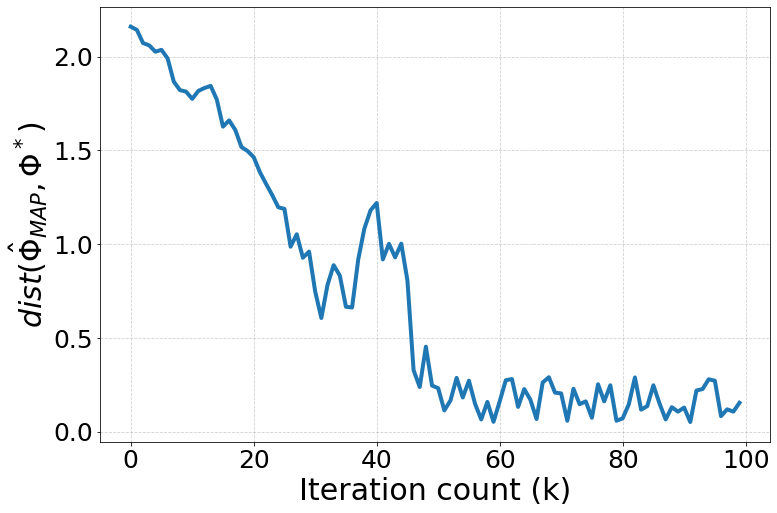

In [45]:
# Error Representation

# Create a plot to show the convergence of the (Log-joint vs iterations)
fig, ax = plt.subplots(figsize=(12,8))


# Plot the data
ax.plot(list(range(int(len(Error_CAMAP)))), Error_CAMAP, linestyle='-', linewidth=4)

# Set labels and a title
ax.set_xlabel('Iteration count (k)',fontsize=30)
ax.set_ylabel(r'$dist(\hat{\Phi}_{MAP},\Phi^*)$',fontsize=30)
ax.tick_params(axis='both', labelsize=25)

# Customize the grid
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

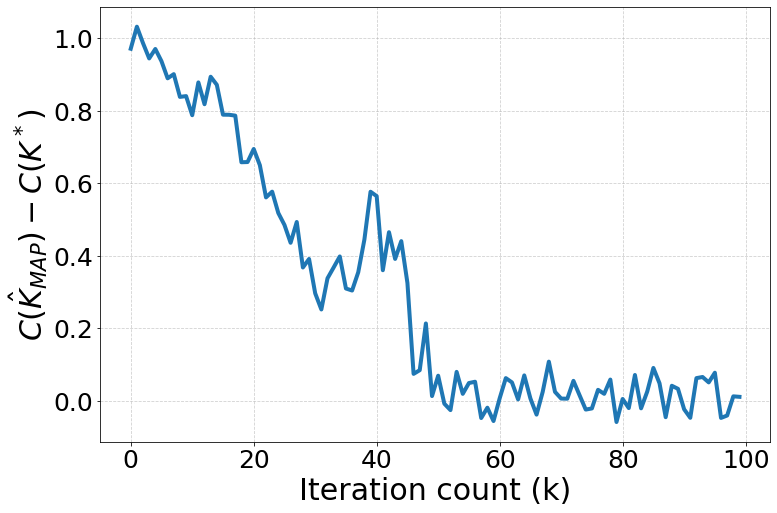

In [80]:
# Error Representation

# Create a plot to show the convergence of the (Log-joint vs iterations)
fig, ax = plt.subplots(figsize=(12,8))


# Plot the data
ax.plot(list(range(int(len(cost_gap)))), cost_gap, linestyle='-', linewidth=4)

# Set labels and a title
ax.set_xlabel('Iteration count (k)',fontsize=30)
ax.set_ylabel(r'$C(\hat{K}_{MAP}) - C(K^*)$',fontsize=30)
ax.tick_params(axis='both', labelsize=25)

# Customize the grid
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()